# Dataset creation

In [1]:
import numpy as np
import pandas as pd

Train: 12-2017 - 11-2019  
Test: 12-2019 - 05-2020

In [37]:
test = pd.read_csv('../data/test_ow.csv', parse_dates=['datetime'], index_col='datetime')
train = pd.read_csv('../data/train_ow.csv', parse_dates=['datetime'], index_col='datetime')
dataset = pd.concat([train, test])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21889 entries, 2017-12-01 00:00:00+00:00 to 2020-05-31 00:00:00+00:00
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   demand              21889 non-null  float64
 1   grid1-load          21889 non-null  float64
 2   grid1-loss          21889 non-null  float64
 3   grid1-temp          21889 non-null  float64
 4   season_x            21889 non-null  float64
 5   season_y            21889 non-null  float64
 6   month_x             21889 non-null  float64
 7   month_y             21889 non-null  float64
 8   week_x              21889 non-null  float64
 9   week_y              21889 non-null  float64
 10  weekday_x           21889 non-null  float64
 11  weekday_y           21889 non-null  float64
 12  holiday             21889 non-null  bool   
 13  hour_x              21889 non-null  float64
 14  hour_y              21889 non-null  float64
 15  has in

In [8]:
dataset['grid1-load'] = dataset['grid1-load'].shift(168)
dataset = dataset.iloc[168:]

In [9]:
dataset.to_csv('../data/dataset_all.csv') # save dataset

## Create datasets for individual hours

In [7]:
dataset = pd.read_csv('../data/dataset_all.csv',parse_dates=['datetime'],index_col='datetime')

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21721 entries, 2017-12-08 00:00:00+00:00 to 2020-05-31 00:00:00+00:00
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   demand              21721 non-null  float64
 1   grid1-load          21721 non-null  float64
 2   grid1-loss          21721 non-null  float64
 3   grid1-temp          21721 non-null  float64
 4   season_x            21721 non-null  float64
 5   season_y            21721 non-null  float64
 6   month_x             21721 non-null  float64
 7   month_y             21721 non-null  float64
 8   week_x              21721 non-null  float64
 9   week_y              21721 non-null  float64
 10  weekday_x           21721 non-null  float64
 11  weekday_y           21721 non-null  float64
 12  holiday             21721 non-null  bool   
 13  hour_x              21721 non-null  float64
 14  hour_y              21721 non-null  float64
 15  has in

In [9]:
dataset.drop('has incorrect data', axis=1, inplace=True)

In [43]:
FOLDER_NAME = 'datasets'

import os
if not os.path.exists(f'../data/{FOLDER_NAME}'):
    os.mkdir(f'../data/{FOLDER_NAME}')

In [45]:
# calculate linear and nonlinear correlations
def correls(dataset):
    corrs = dataset.loc[:'11-2019'].corr().sort_values('grid1-loss')[['grid1-loss']].rename({'grid1-loss':'linear'},axis=1)
    corrs['log'] = dataset.loc[:'11-2019'].apply(np.log).corr().sort_values('grid1-loss')[['grid1-loss']]
    corrs['corr'] = corrs.apply(lambda x: max(abs(x)),axis=1)
    return corrs.sort_values('corr',ascending=False)[['corr']]

corrrs = pd.DataFrame()
for hour in range(24):
    corrrs = pd.concat([corrrs,correls(dataset[(dataset.index.hour == hour)].loc[:'11-2019']).rename({'corr':f'{str(hour).zfill(2)}:00'},axis=1)],axis=1)
        
# create datasets for individual minutes from correlations > +-0.5
for hour in range(24):
    c = corrrs[f'{str(hour).zfill(2)}:00'].apply(abs).sort_values().dropna().reset_index()
    k = c[(c[f'{str(hour).zfill(2)}:00']>.5) & (c[f'{str(hour).zfill(2)}:00']<1)] if len(c[c[f'{str(hour).zfill(2)}:00']>.5]) > 2 else c[-3:]
    print(f'{str(hour).zfill(2)}:00 - {", ".join([f"{i[1][0]} ({i[1][1]:.3})" for i in k.iterrows()])}')
    d = dataset[(dataset.index.hour == hour)][['grid1-loss',*[f"{i[1][0]}" for i in k.iterrows()]]]
    d.to_csv(f'../data/{FOLDER_NAME}/{str(hour).zfill(2)}_00.csv')

00:00 - season_y (0.555), snow_depth (0.63), season_x (0.743), week_x (0.759), month_x (0.792), grid1-temp (0.868), grid1-load (0.873), dew_point (0.88), temperature (0.886), demand (0.947)
01:00 - season_y (0.544), snow_depth (0.601), season_x (0.737), week_x (0.752), month_x (0.785), grid1-load (0.869), grid1-temp (0.874), dew_point (0.882), temperature (0.886), demand (0.947)
02:00 - season_y (0.537), snow_depth (0.576), season_x (0.733), week_x (0.747), month_x (0.781), grid1-load (0.866), grid1-temp (0.878), dew_point (0.882), temperature (0.886), demand (0.947)
03:00 - snow_depth (0.52), season_y (0.535), season_x (0.728), week_x (0.741), month_x (0.773), grid1-load (0.861), grid1-temp (0.88), dew_point (0.882), temperature (0.888), demand (0.945)
04:00 - season_y (0.524), season_x (0.711), week_x (0.718), month_x (0.748), grid1-load (0.848), dew_point (0.874), grid1-temp (0.879), temperature (0.883), demand (0.935)
05:00 - season_x (0.689), week_x (0.702), month_x (0.725), dew_p

## Add EWMA feature

In [43]:
import pandas as pd

In [44]:
FOLDER_NAME = 'datasets'
FOLDER_NAME2 = 'datasets_ewma'

In [80]:
for hour in range(24):
    data = pd.read_csv(f'../data/{FOLDER_NAME}/{hour:02}_00.csv',parse_dates=['datetime'],index_col='datetime')
    data.index.freq = 'D'
    data['ewma'] = SimpleExpSmoothing(data['grid1-loss']).fit(
        smoothing_level=SimpleExpSmoothing(data['grid1-loss'].loc[:'11-2019']).fit().params['smoothing_level'], 
        optimized=False).fittedvalues
    data.to_csv(f'../data/{FOLDER_NAME2}/{hour:02}_00.csv')

<AxesSubplot:xlabel='datetime'>

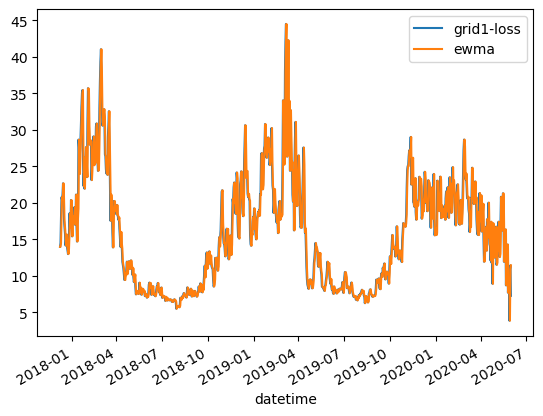

In [82]:
data[['grid1-loss','ewma']].plot()